# Imports and Setup

In [29]:
import random
import os

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange
import numpy as np

# Fix for Gym expecting np.bool8 (removed in NumPy 1.24+)
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

%matplotlib inline


# ReplayBuffer class

In [8]:
class ReplayBuffer:
    """Simple cyclic replay buffer for DQN."""

    def __init__(self, capacity: int):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)


# DQN network and agent

In [9]:
class DQN(nn.Module):
    """Simple MLP Q-network for CartPole."""

    def __init__(self, state_dim: int, action_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class DQNAgent:
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        lr: float = 1e-3,
        gamma: float = 0.99,
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.01,
        epsilon_decay: float = 0.995,
        device: str = None,
    ):
        self.action_dim = action_dim
        self.gamma = gamma
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)

        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay

    def choose_action(self, state: np.ndarray) -> int:
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)

        state_t = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state_t)
        return int(torch.argmax(q_values, dim=1).item())

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def train_step(
        self,
        states: np.ndarray,
        actions: np.ndarray,
        rewards: np.ndarray,
        next_states: np.ndarray,
        dones: np.ndarray,
    ) -> float:
        states_t = torch.FloatTensor(states).to(self.device)
        actions_t = torch.LongTensor(actions).to(self.device)
        rewards_t = torch.FloatTensor(rewards).to(self.device)
        next_states_t = torch.FloatTensor(next_states).to(self.device)
        dones_t = torch.FloatTensor(dones).to(self.device)

        q_values = self.policy_net(states_t)
        q_value = q_values.gather(1, actions_t.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            next_q_values = self.target_net(next_states_t)
            max_next_q_values, _ = next_q_values.max(dim=1)
            target = rewards_t + self.gamma * max_next_q_values * (1.0 - dones_t)

        loss = nn.MSELoss()(q_value, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return float(loss.item())

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())


# Helper Functions

In [10]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def reset_env(env):
    """Handle Gym vs Gymnasium reset API."""
    out = env.reset()
    if isinstance(out, tuple):
        state, _info = out
    else:
        state = out
    return state


def step_env(env, action):
    """Handle Gym vs Gymnasium step API."""
    out = env.step(action)
    if len(out) == 5:
        next_state, reward, terminated, truncated, _info = out
        done = terminated or truncated
    else:
        next_state, reward, done, _info = out
    return next_state, reward, done


# Initialize environment, agent, and buffer

In [11]:
set_seed(42)

env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    lr=1e-3,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995,
)

buffer = ReplayBuffer(capacity=50_000)

num_episodes = 500
batch_size = 64
max_steps_per_episode = 500
target_update_freq = 50

rewards_history = []
losses_history = []

os.makedirs("results", exist_ok=True)


/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Training loop

In [13]:
for episode in trange(num_episodes, desc="Training"):
    state = reset_env(env)
    episode_reward = 0.0

    for _ in range(max_steps_per_episode):
        action = agent.choose_action(state)
        next_state, reward, done = step_env(env, action)

        buffer.push(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward

        if len(buffer) >= batch_size:
            s, a, r, s2, d = buffer.sample(batch_size)
            loss = agent.train_step(s, a, r, s2, d)
            losses_history.append(loss)

        if done:
            break

    rewards_history.append(episode_reward)
    agent.update_epsilon()

    if (episode + 1) % target_update_freq == 0:
        agent.update_target_network()

env.close()


Training: 100%|██████████| 500/500 [01:26<00:00,  5.75it/s]


# Reward Curve


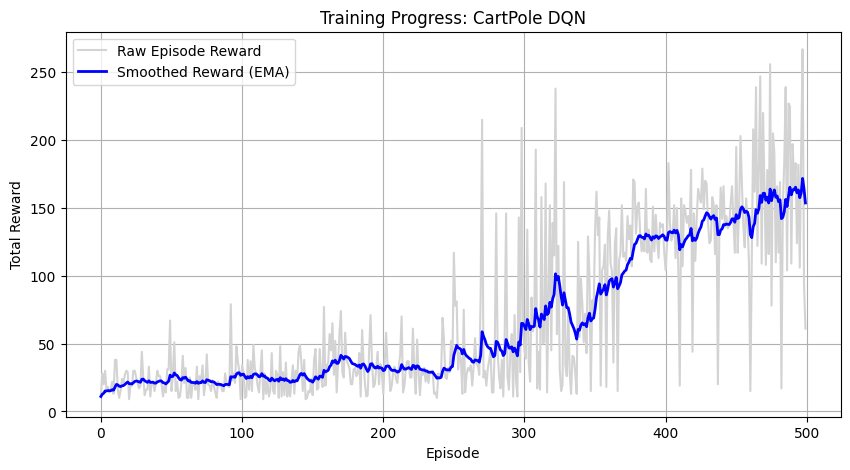

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def smooth(data, weight=0.9):
    """Smooths data using exponential moving average."""
    smoothed = []
    last = data[0]
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

smoothed_rewards = smooth(rewards_history, weight=0.9)

plt.figure(figsize=(10, 5))
plt.plot(rewards_history, color='lightgray', label="Raw Episode Reward")
plt.plot(smoothed_rewards, color='blue', linewidth=2, label="Smoothed Reward (EMA)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress: CartPole DQN")
plt.legend()
plt.grid(True)
plt.show()


# Plotting Curves


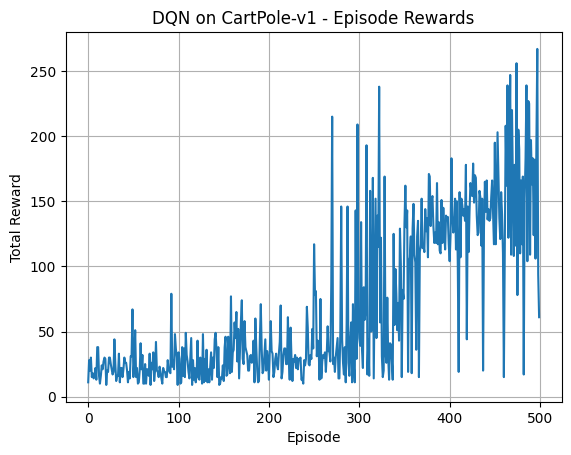

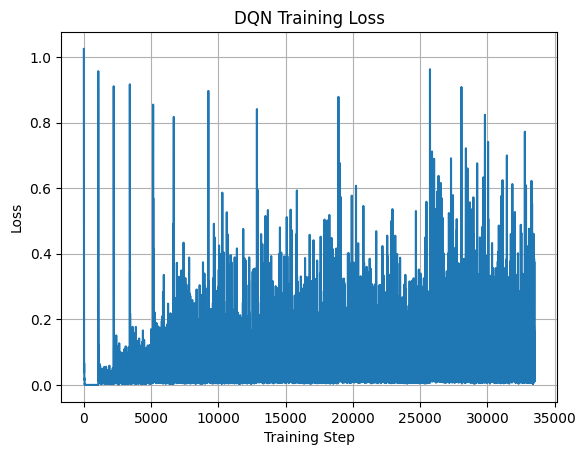

In [17]:
plt.figure()
plt.plot(rewards_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN on CartPole-v1 - Episode Rewards")
plt.grid(True)
plt.show()

if len(losses_history) > 0:
    plt.figure()
    plt.plot(losses_history)
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.title("DQN Training Loss")
    plt.grid(True)
    plt.show()


# Evaluation

In [32]:
def evaluate_agent(env, agent: DQNAgent, render: bool = False) -> float:
    state = reset_env(env)
    done = False
    total_reward = 0.0

    while not done:
        if render:
            env.render()

        state_t = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
        with torch.no_grad():
            q_values = agent.policy_net(state_t)
        action = int(torch.argmax(q_values, dim=1).item())

        next_state, reward, done = step_env(env, action)
        total_reward += reward
        state = next_state

    return total_reward


env = gym.make("CartPole-v1")  # fresh env for eval
eval_reward = evaluate_agent(env, agent, render=False)
env.close()

print(f"Evaluation reward (no exploration): {eval_reward:.1f}")


Evaluation reward (no exploration): 102.0


# Average Reward

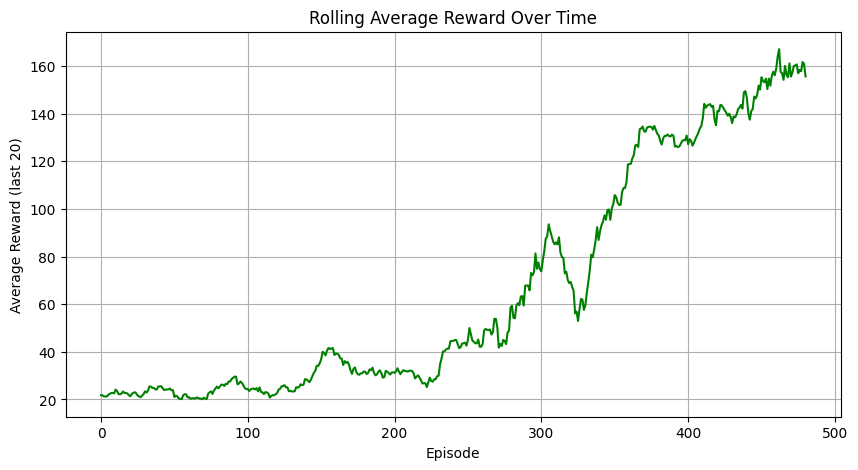

In [34]:
window = 20
rolling_avg = np.convolve(rewards_history,
                          np.ones(window) / window,
                          mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(rolling_avg, color='green')
plt.xlabel("Episode")
plt.ylabel(f"Average Reward (last {window})")
plt.title("Rolling Average Reward Over Time")
plt.grid(True)
plt.show()


#Loss Curve

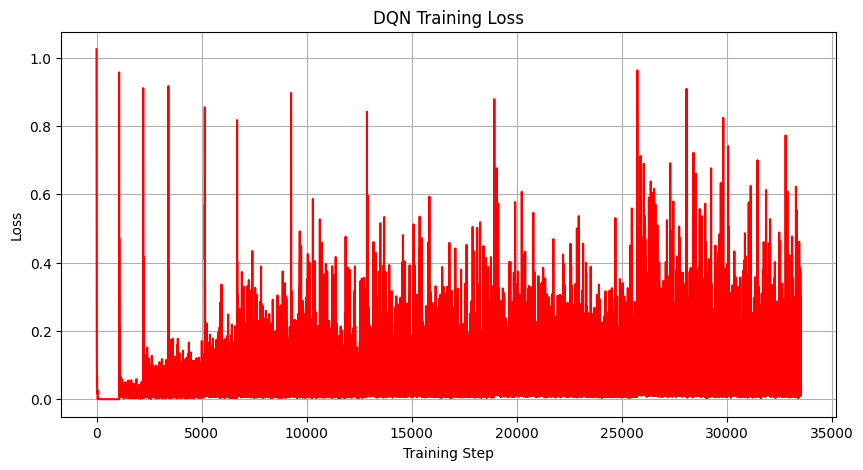

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(losses_history, color='red')
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("DQN Training Loss")
plt.grid(True)
plt.show()


# Sucess Over Time

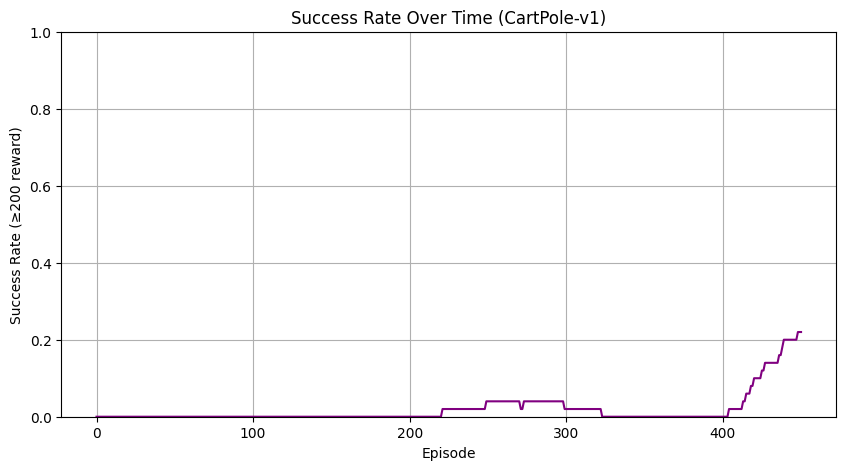

In [36]:
threshold = 200
success = [1 if r >= threshold else 0 for r in rewards_history]
success_rate = np.convolve(success, np.ones(50)/50, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(success_rate, color='purple')
plt.xlabel("Episode")
plt.ylabel("Success Rate (≥200 reward)")
plt.title("Success Rate Over Time (CartPole-v1)")
plt.ylim([0, 1])
plt.grid(True)
plt.show()